<a href="https://colab.research.google.com/github/slopatek/Crude_Oil_Prices_Time_Series_Analysis/blob/main/Crude_Oil_Prices_TSA_Part_01_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Crude Oil Prices - Time Series Analysis (Part 1)**

The ultimate objective is to model crude oil prices using machine learning techniues. As all ML practicioners know very well, time series analysis for open systems (and market indices in particular) is very challenging task where expectations should be kept in check. That will not stop us though from a few useful experiments. First things first - let's see what we are dealing with...

# **Preparing the ground**

Let's import usual suspects, code some useful functions and eventually download the data, that we will work with....

##**Required imports**

In [1]:
# the module will be useful later when searching for optimum ARIMA model
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.1 MB/s 
     |████████████████████████████████| 9.9 MB 37.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from warnings import catch_warnings, filterwarnings, simplefilter
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats.distributions import chi2
from pmdarima import auto_arima
import seaborn as sns
sns.set()
import itertools
import datetime as dt
from timeit import default_timer as timer

simplefilter("ignore")

##**Useful functions**

They will save us some time at a later stage.

In [23]:
def LLR_test(model_1, model_2, deg_of_fred = 1):
  LL1 = model_1.fit().llf
  LL2 = model_2.fit().llf
  LR = (2*(LL2 - LL1))
  p = chi2.sf(LR, deg_of_fred).round(3)
  return p

def train_test_splitting(data, test_percent = 0.10):
  test_size = int(len(data) * test_percent)
  #return np.array(data[:-test_size]), np.array(data[-test_size:])
  return data[:-test_size], data[-test_size:]
  
def calculate_rmse(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true)))

def assess_predictions(actual_data, predicted_data):
  prediction_error = np.round(calculate_rmse(actual_data, predicted_data),3)
  return prediction_error

def stationarity_check(series):
  outcome =[]
  result = adfuller(series)
  for key, value in result[4].items():
    if result[0]<value:
      outcome.append((key,True))
    else:
      outcome.append((key,False))
  if outcome[0][1] == outcome[1][1] == outcome[2][1] == True:
    verdict = 'Stationary'
  elif outcome[0][1] == outcome[1][1] == outcome[2][1] == False:
    verdict = 'Not Stationary'
  else:
    verdict = 'Depends'
  return verdict, outcome

def first_diff(time_series):
  if type(time_series) != pd.core.frame.DataFrame:
    df_time_series = pd.DataFrame(time_series)
  else:
    df_time_series = time_series.iloc[: , -1:]
  return df_time_series.diff().dropna()

def series_decomposition(time_series):
  decomposition = seasonal_decompose(time_series, model = "additive", period = 30)
  trend, seasonal, residual = decomposition.trend, decomposition.seasonal, decomposition.resid
  f = plt.figure(facecolor='white', figsize = (15,4))
  ax1, ax2, ax3 = f.add_subplot(131), f.add_subplot(132), f.add_subplot(133)
  ax1.plot(trend), ax2.plot(seasonal), ax3.plot(residual)
  ax1.set_title('Trend - ' + time_series.name)
  ax2.set_title('Seasonal - ' + time_series.name)
  ax3.set_title('Residual - ' + time_series.name)
  plt.tight_layout()

##**Data retrieval**

Two major crude oil futures contracts are WTI (West Texas Intermediate) traded on NYMEX (New York Mercantile Exchange) and Brent traded on ICE (InterContinental Exchange) in London. We will choose to work with the latter one as it has much more global scope.

In [4]:
brent = pd.read_csv("ICE_Brent.csv", sep = ";", usecols = ["Date", "Close"], index_col = "Date", parse_dates = True)
brent["Close"] = brent["Close"].str.replace(',', '.').astype("float64")

# **Explanatory Data Analysis**

Let's see what exatly we are dealing with here, how data is being distributed, what characteristics it exibits, is it stationary, does it show time dependence etc. etc.

##**Price history**

Quick check of potential missing values

In [5]:
brent.isna().sum()

Close    0
dtype: int64

Visualizing price behavior since 1988

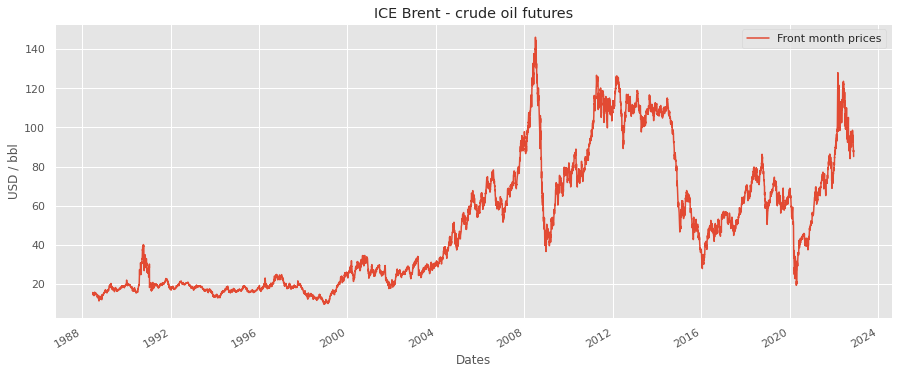

In [6]:
plt.style.use("ggplot")
brent.Close.plot(figsize=(15,6), label = "Front month prices")
plt.title("ICE Brent - crude oil futures")
plt.ylabel("USD / bbl")
plt.xlabel("Dates")
plt.legend();

##**Distribution of Brent prices**

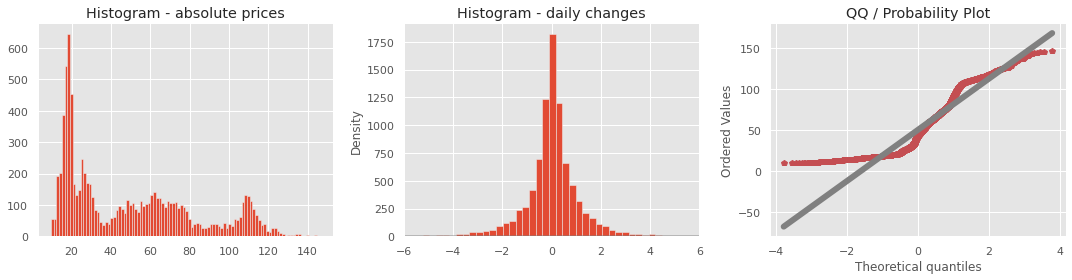

In [8]:
fig = plt.figure(figsize=(15,4))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
ax1.hist(brent.Close, bins=100)
ax1.set_title("Histogram - absolute prices")
ax2.hist(brent.Close.diff().dropna(), bins=100)
ax2.set_xlim(-6,6)
ax2.set_title("Histogram - daily changes")
brent.Close.diff().dropna().plot.kde(ax=ax2, color = "grey")
scipy.stats.probplot(brent.Close, plot = ax3)
ax3.get_lines()[0].set_marker('p')
ax3.get_lines()[0].set_markerfacecolor('r')
ax3.get_lines()[0].set_markersize(6.0)
ax3.get_lines()[0].set_markeredgecolor("r")
ax3.get_lines()[1].set_linewidth(6.0)
ax3.get_lines()[1].set_color("grey")
ax3.set_title("QQ / Probability Plot")
plt.tight_layout()
plt.show();

* Absolute prices show three distinct clusters: 
1.   around 20 USD/bbl - mostly in the period 1988 - 2004
2.   around 65 & 110 USD/bbl - past 2004, which may serve as proxy for low price and highe price environment respectively

* It is tempting to say that daily price changes follow Gaussian distribution based on histogram od daily changes, nevertheless...

* QQ (quantile-quantile) plot clearly shows that Brent prices do not follow normal distribution. Hence we cannot use elegant statistics of normal distribution to make successful forecasts. That's actually what we usually expect from market data. No surprises here...

##**White Noise**

The question is whether data follows some kind of pattern or could be described as a white noise under three conditions:
1.   constant mean
2.   constant variance
3.   no autocorrelation

Let's generate White Nosie data, plot its values and compare to respective Brent values.

In [9]:
white_noise = np.random.normal(loc = brent.Close.mean(),
                               scale = brent.Close.std(),
                               size = len(brent))
brent["white_noise"] = white_noise
brent.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,8793.0,50.086072,33.040581,9.640000,19.480000,43.300000,72.130000,146.080000
white_noise,8793.0,49.260202,32.771079,-88.613199,27.329648,49.145666,71.805987,160.280211


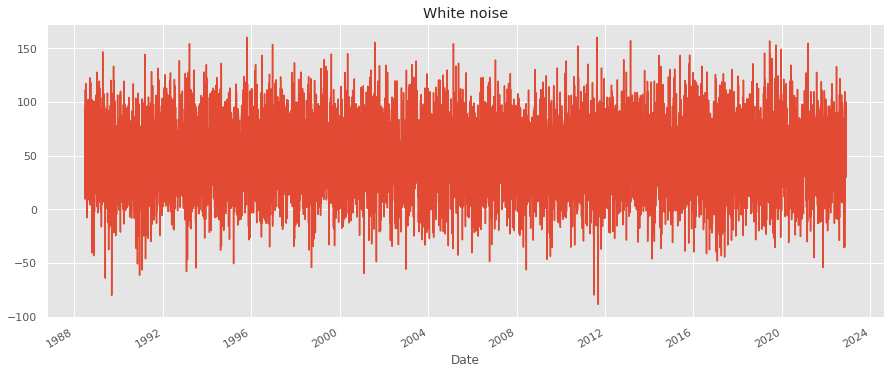

In [10]:
brent.white_noise.plot(figsize=(15,6))
plt.title("White noise")
plt.show();

We may conclude that Brent prices are not random and do not represent white noise characteristics. The search for a pattern continues....

##**Random Walk**

Let's shift our focus to a special type of time series called random walk. Its values tend to persist over time and periodical changes are basicaly white noise (mentioned above).

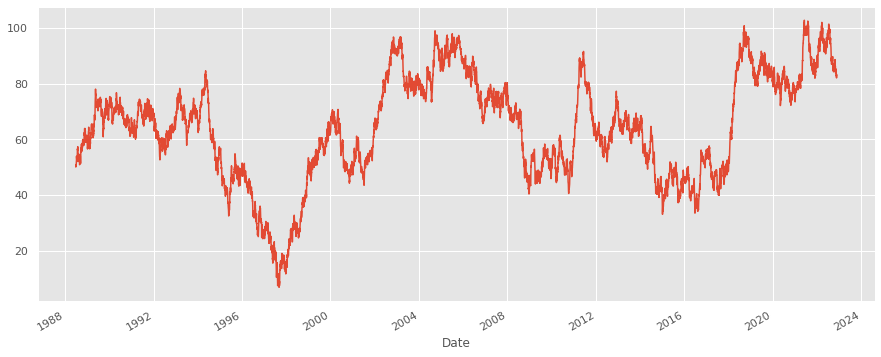

In [11]:
random_walk = [brent.Close.mean()]
for i in range(len(brent)-1):
  next = random_walk[i] + np.random.normal(loc=0, scale = 1)
  random_walk.append(next)

brent["random_walk"] = random_walk
brent.random_walk.plot(figsize=(15,6));

Unlike white noise, random walk process indeed resembles crude oil price formation or... acctually the other way around.

##**Stationarity**

Let us examine a week-form stationarity (covarience stationarity) of our data which assumes:

> 1) constant mean

> 2) constant variance

> 3) constant covariance across periods


In [13]:
brent_verdict, brent_tests = stationarity_check(brent["Close"])
print('Brent =>  ', brent_verdict, '   Tests  =>   ', brent_tests)

Brent =>   Not Stationary    Tests  =>    [('1%', False), ('5%', False), ('10%', False)]


In [14]:
wn_verdict, wn_tests = stationarity_check(brent["white_noise"])
print('White noise =>  ', wn_verdict, '   Tests  =>   ', wn_tests)

White noise =>   Stationary    Tests  =>    [('1%', True), ('5%', True), ('10%', True)]


In [15]:
# RW needs to be created first
rw_verdict, rw_tests = stationarity_check(brent["random_walk"])
print('Random walk =>  ', rw_verdict, '   Tests  =>   ', rw_tests)

Random walk =>   Not Stationary    Tests  =>    [('1%', False), ('5%', False), ('10%', False)]


As we would expect - White Noise process turns out to be stationary, while Brent Prices and Random Walk are not stationary.

Let's not stop here and try to **transform** Brent prices in order to obtain a stationary series. We will use first differencing.

In [17]:
brent_first_diff = first_diff(brent["Close"])
brent_diff_verdict, brent_diff_tests = stationarity_check(brent_first_diff)
print('Brent diff =>  ', brent_diff_verdict)
print('Brent diff tests =>   ', brent_diff_tests)

Brent diff =>   Stationary
Brent diff tests =>    [('1%', True), ('5%', True), ('10%', True)]


Time series of Brent prices has been successfylly transformed into stationary series of first differences which will be usefull at a later stage.

And that is how first differences present themselves...

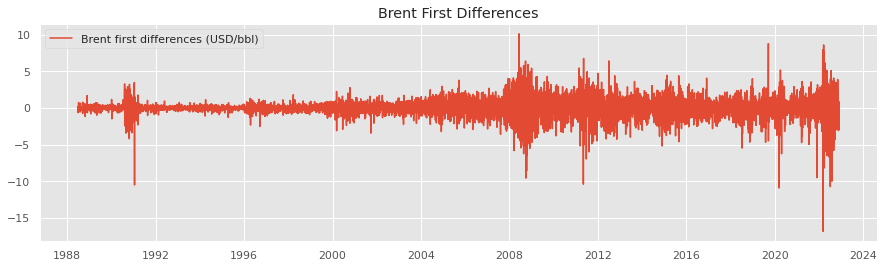

In [18]:
f = plt.figure(figsize = (15,4))
plt.plot(brent_first_diff, label = "Brent first differences (USD/bbl)")
plt.title('Brent First Differences')
plt.legend();

##**TS decomposition**

It would be nice to split price dynamics into three disctinct categaories now: 1) trend 2) seasonal 3) residual

We will use the dedicated function for that purpose.

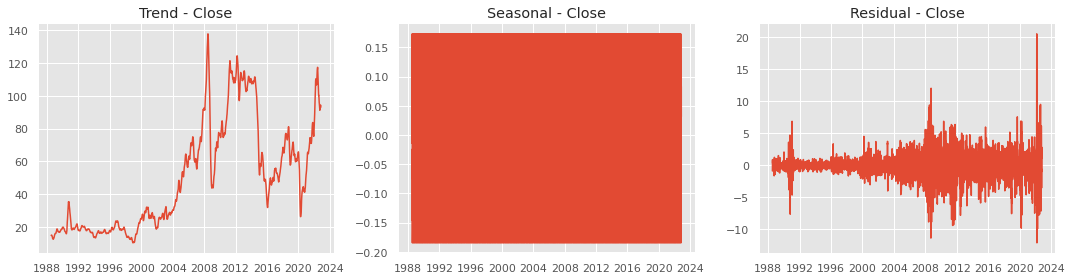

In [24]:
series_decomposition(brent.Close)

Daily data of Brent prices indicates lack of seasonality component.

##**Autocorrelation**

Let's now check if Brent prices are correlated with its past values.

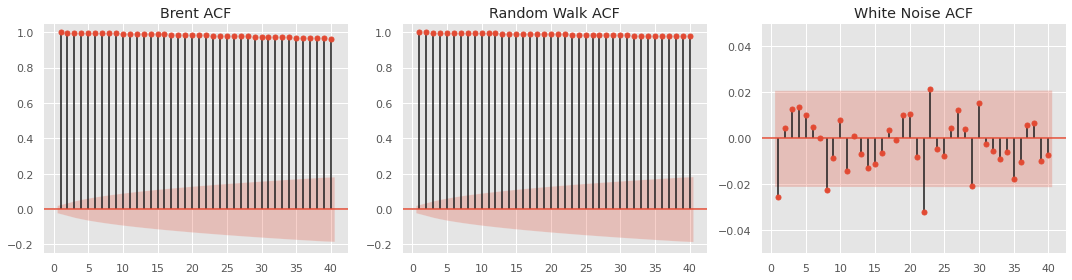

In [ ]:
f = plt.figure(figsize = (15,4)) #facecolor='white'
ax1, ax2, ax3 = f.add_subplot(131), f.add_subplot(132), f.add_subplot(133)
plot_acf(brent.Close, lags=40, ax=ax1, zero = False, title = "Brent ACF")
ax1.set_ylim(bottom = -0.25, top = 1.05)
plot_acf(brent.random_walk, lags=40, ax=ax2, zero = False, title = "Random Walk ACF")
ax2.set_ylim(bottom = -0.25, top = 1.05)
plot_acf(brent.white_noise, lags=40, ax=ax3, zero = False, title = "White Noise ACF")
ax3.set_ylim(bottom = -0.05, top = 0.05)
plt.tight_layout()

ACF chart is indicative of time dependence in the Brent price data. The autocorrelation barely diminishes as the lag increases. Similar behaviur is observed for random walk while white noise process is very different with values flipping constantly from positive to negative and the other way around while staying within reddish area indicating their insignificance.

##**Partial Autocorrelation**

Another function (PACF) helps to determine direct relationship with lagged value after accounting for indirect relationship.

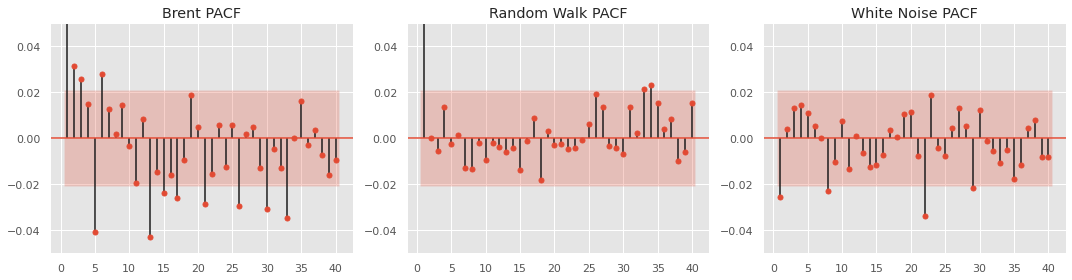

In [ ]:
f = plt.figure(figsize = (15,4))
ax1, ax2, ax3 = f.add_subplot(131), f.add_subplot(132), f.add_subplot(133)
plot_pacf(brent.Close, lags=40, ax=ax1, zero = False, method = ('ols'), title = "Brent PACF")
ax1.set_ylim(bottom = -0.05, top = 0.05)
plot_pacf(brent.random_walk, lags=40, ax=ax2, zero = False, method = ('ols'), title = "Random Walk PACF")
ax2.set_ylim(bottom = -0.05, top = 0.05)
plot_pacf(brent.white_noise, lags=40, ax=ax3, zero = False, method = ('ols'), title = "White Noise PACF")
ax3.set_ylim(bottom = -0.05, top = 0.05)
plt.tight_layout()

Quite a few of them are significantly different from zero. In stark contrast to ACF values, some of the elements are negative which is indicative pf price correction action.

# **Models tried**

Now would be a good moment to try modeling Brent prices using different approaches.


## **AR**

Let us remind ourselves that ACF chart is indicative of time dependence in the Brent price data. The autocorrelation is significant at all chosen legs and barely diminishes as the lag increases.

Basically the more lags we include in the model, the better it should fit the data but we should be cautious not to overfit so it is not prone to mistakes when forecasting future values. We should attempt to build parsimonious one.

Since ACF capture both direct and indirect relationship we should examine PACF. Since value at first lag eclipses all other values which are just on the very edge of being significant we can start with AR(1) model.

In [25]:
model_ar_1 = ARIMA(brent.Close, order=(1,0,0))
results_ar_1 = model_ar_1.fit()
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 8793
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -14252.257
Date:                Thu, 29 Dec 2022   AIC                          28510.515
Time:                        10:41:31   BIC                          28531.760
Sample:                             0   HQIC                         28517.753
                               - 8793                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0861     20.191      2.481      0.013      10.512      89.660
ar.L1          0.9993      0.000   2718.868      0.000       0.999       1.000
sigma2         1.4964      0.008    179.975      0.000       1.480       1.513
===================================================================================
Ljung-Box (L1) (Q):                   8.74   Jarque-Bera (JB):             68255.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.17   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

P-values indicate that both intercept and coefficient are significant (95% confidence interval is a clear confirmation of the fact).

Coefficient of regresion value from one period ago @ 0.9993 is very close to one which is what we would expect based on previous analysis.

Let's see how higher-rank AR models do....

In [26]:
models_lst, ll_lst, aic_lst = [], [], []
for AR in range(1,9):
  globals()[f"model_ar_{AR}"] = ARIMA(brent.Close, order=(AR,0,0))
  globals()[f"results_ar_{AR}"] = globals()[f"model_ar_{AR}"].fit() # start_ar_lag = 5
  if all(globals()[f"results_ar_{AR}"].pvalues<0.05):
    models_lst.append(f"AR({AR})")
    ll_lst.append(globals()[f"results_ar_{AR}"].llf.round(2))
    aic_lst.append(globals()[f"results_ar_{AR}"].aic.round(2))
  print("#"*100)
  print(f"AR({AR})")
  print(globals()[f"results_ar_{AR}"].summary())

ar_results_dict = {"LL": ll_lst,
                   "AIC": aic_lst}
ar_results_df = pd.DataFrame(ar_results_dict, index = models_lst)
ar_results_df

####################################################################################################
AR(1)
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8793
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -14252.257
Date:                Thu, 29 Dec 2022   AIC                          28510.515
Time:                        10:42:41   BIC                          28531.760
Sample:                             0   HQIC                         28517.753
                               - 8793                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0861     20.191      2.481      0.013      10.512      89.660
ar.L1          0.9993   

,LL,AIC
AR(1),-14252.26,28510.51
AR(2),-14247.88,28503.75


Only two models have all coefficients significant. Let's check if higher complexity is justified here. Log-Likeluhood test will come handy for that purpose.

In [ ]:
LLR_test(model_ar_1, model_ar_2)

0.003

Yes, indeed. The choice should be made in favor of the more complex model of AR(2) after all. We should nevertheless remember that AR models in general should do poorly for non-stationary data and it would be advisable to transform our time-series into stationary process for further modeling.

**Returns**

Let's switch now from absolute prices to their returns. We will use daily percantage change of price stored in the Returns column.

In [27]:
brent["Returns"] = brent.Close.pct_change(1).mul(100)
brent = brent.iloc[1:]   # dropping NaN value from the first raw

In [28]:
sts.adfuller(brent.Returns)

(-17.925292102472053,
 2.8962933058074033e-30,
 22,
 8769,
 {'1%': -3.4310959476880325,
  '5%': -2.861869659409052,
  '10%': -2.5669454727258514},
 39365.56225375132)

Since the test statistic falls far to the left of even 1% of critical value... we may confidently conclude that the data comes from the stationary process. Let's have a look at ACF and PACF plots.

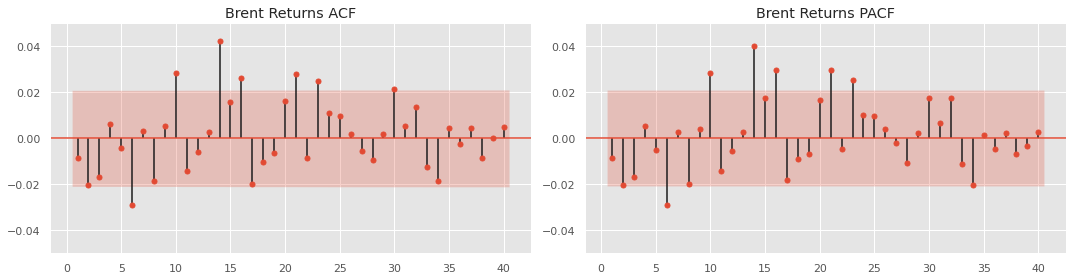

In [ ]:
f = plt.figure(figsize = (15,4)) #facecolor='white'
ax1, ax2 = f.add_subplot(121), f.add_subplot(122)
plot_acf(brent.Returns, lags=40, ax=ax1, zero = False, title = "Brent Returns ACF")
ax1.set_ylim(bottom = -0.05, top = 0.05)
plot_pacf(brent.Returns, lags=40, ax=ax2, zero = False, title = "Brent Returns PACF")
ax2.set_ylim(bottom = -0.05, top = 0.05)
plt.tight_layout()

What a change?
1.   not all values are significant
2.   values greatly vary in magnitude instead of all being close to one

First significant coefficient is negative which is indicative of some price adjustment process. 

PACF values in this case are much more in line with ACF values.



**AR(1)**

In [29]:
model_ret_ar_1 = ARIMA(brent.Returns, order=(1,0,0))
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                 8792
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -19779.156
Date:                Thu, 29 Dec 2022   AIC                          39564.311
Time:                        10:45:07   BIC                          39585.556
Sample:                             0   HQIC                         39571.549
                               - 8792                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0459      0.024      1.876      0.061      -0.002       0.094
ar.L1         -0.0086      0.006     -1.515      0.130      -0.020       0.003
sigma2         5.2671      0.029    182.610      0.000       5.211       5.324
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             67236.95
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.52
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Neither coefficient is significantly different from zero. We will now check whether a higher-lag model surves as better predictor of Brent returns.

In [31]:
models_lst, ll_lst, aic_lst = [], [], []
for AR in range(1,9):
  globals()[f"model_ret_ar_{AR}"] = ARIMA(brent.Returns, order=(AR,0,0))
  globals()[f"results_ret_ar_{AR}"] = globals()[f"model_ret_ar_{AR}"].fit() # start_ar_lag = 5
  if all(globals()[f"results_ret_ar_{AR}"].pvalues<0.05):
    models_lst.append(f"AR({AR})")
    ll_lst.append(globals()[f"results_ret_ar_{AR}"].llf.round(2))
    aic_lst.append(globals()[f"results_ret_ar_{AR}"].aic.round(2))
  print("#"*100)
  print(f"AR({AR})")
  print(globals()[f"results_ret_ar_{AR}"].summary())

ar_ret_results_dict = {"LL": ll_lst,
                   "AIC": aic_lst}
ar_ret_results_df = pd.DataFrame(ar_ret_results_dict, index = models_lst)
ar_ret_results_df

####################################################################################################
AR(1)
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 8792
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -19779.156
Date:                Thu, 29 Dec 2022   AIC                          39564.311
Time:                        10:45:52   BIC                          39585.556
Sample:                             0   HQIC                         39571.549
                               - 8792                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0459      0.024      1.876      0.061      -0.002       0.094
ar.L1         -0.0086   

,LL,AIC


Regretably none of the models yielded all significant coefficients. 

Let see if we can model Brent prices using moving average process.

## **MA**

Checking the potential for a self-correcting model which takes into account past residuals which in theory should give them skill to adjust to shocks more quickly thanks to mechanism of correction following big errors. The more of them are being examined - the better adaptation to some unforseen events. It is considered to be skillful particularly for a random walk type of process.

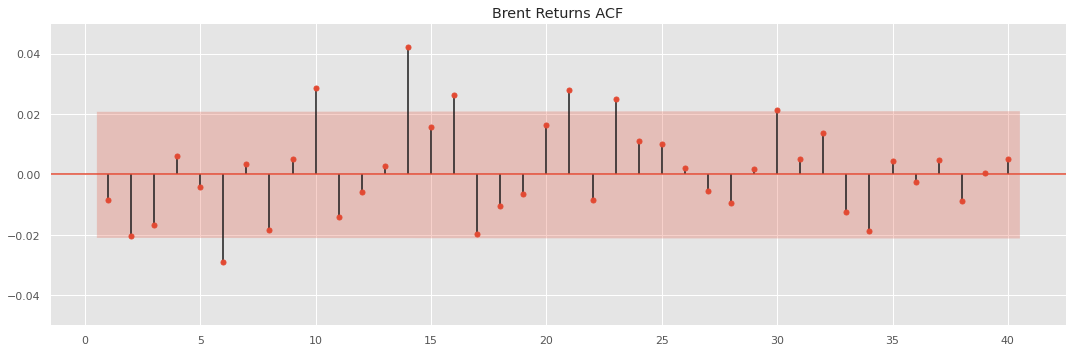

In [ ]:
f = plt.figure(figsize = (15,5))
ax1 = f.add_subplot(111)
plot_acf(brent.Returns, lags=40, ax=ax1, zero = False, title = "Brent Returns ACF")
ax1.set_ylim(bottom = -0.05, top = 0.05)
plt.tight_layout()

In [32]:
models_lst, ll_lst, aic_lst = [], [], []
for MA in range(1,11):
  globals()[f"model_ret_ma_{MA}"] = ARIMA(brent.Returns, order=(0,0,MA))
  globals()[f"results_ret_ma_{MA}"] = globals()[f"model_ret_ma_{MA}"].fit() # start_ar_lag = 5
  if all(globals()[f"results_ret_ma_{MA}"].pvalues<0.05):
    models_lst.append(f"MA({MA})")
    ll_lst.append(globals()[f"results_ret_ma_{MA}"].llf.round(2))
    aic_lst.append(globals()[f"results_ret_ma_{MA}"].aic.round(2))
  print("#"*100)
  print(f"MA({MA})")
  print(globals()[f"results_ret_ma_{MA}"].summary())

ma_ret_results_dict = {"LL": ll_lst,
                   "AIC": aic_lst}
ma_ret_results_df = pd.DataFrame(ma_ret_results_dict, index = models_lst)
ma_ret_results_df

####################################################################################################
MA(1)
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 8792
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -19779.142
Date:                Thu, 29 Dec 2022   AIC                          39564.283
Time:                        10:46:49   BIC                          39585.528
Sample:                             0   HQIC                         39571.521
                               - 8792                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0459      0.024      1.877      0.061      -0.002       0.094
ma.L1         -0.0089   

,LL,AIC


Just like with AR, unfortunately none of the MA models yielded all significant coefficients.

Let see if we can model Brent prices using combination of the two in the ARMA / ARIMA process.

## **ARMA**

Let us construct a model which includes both past values and past errors and which solves the issues each one of them (AR & MA) has individually.

In [33]:
model_ret_ar_1_ma_1 = ARIMA(brent.Returns, order=(1,0,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Returns   No. Observations:                 8792
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -19776.610
Date:                Thu, 29 Dec 2022   AIC                          39561.220
Time:                        10:47:26   BIC                          39589.546
Sample:                             0   HQIC                         39570.870
                               - 8792                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0460      0.023      1.963      0.050    6.64e-05       0.092
ar.L1          0.7308      0.111      6.571      0.000       0.513       0.949
ma.L1         -0.7482      0.108     -6.904      0.000      -0.961      -0.536
sigma2         5.2640      0.029    179.005      0.000       5.206       5.322
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):             67030.00
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

P-values indicate significance of all coefficients. At the same time AR1 coefficient indicates highly positive tendency between past and present values while Brent price returns move in trends of consecutive positive and negative values. The negative MA coefficient suggest that we should be going away from the previous period value.

In [ ]:
print("ARMA vs AR => ", LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1))
print("ARMA vs MA => ", LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1))

ARMA vs AR =>  0.024
ARMA vs MA =>  0.024


Both results suggest that using past errors along with past values helps to obtain much better estimators.

## **ARIMA**

Since we know that Brent crude prices follow non-stationary process while their returns exibit stationary characteristics we may attempt to model the series using ARIMA process with one level of integration.

Let's start with the simplest one...

In [34]:
model_ar_1_i_1_ma_1 = ARIMA(brent.Close, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 8792
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14240.655
Date:                Thu, 29 Dec 2022   AIC                          28487.310
Time:                        10:47:54   BIC                          28508.555
Sample:                             0   HQIC                         28494.548
                               - 8792                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4563      0.109      4.194      0.000       0.243       0.669
ma.L1         -0.4916      0.105     -4.668      0.000      -0.698      -0.285
sigma2         1.4947      0.008    177.863      0.000       1.478       1.511
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             66976.24
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              10.20   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# adding residuals to a data frame
brent["ARIMA_Residuals"] = results_ar_1_i_1_ma_1.resid

Both coefficients are statistically significant. Let's have a look at residuals...


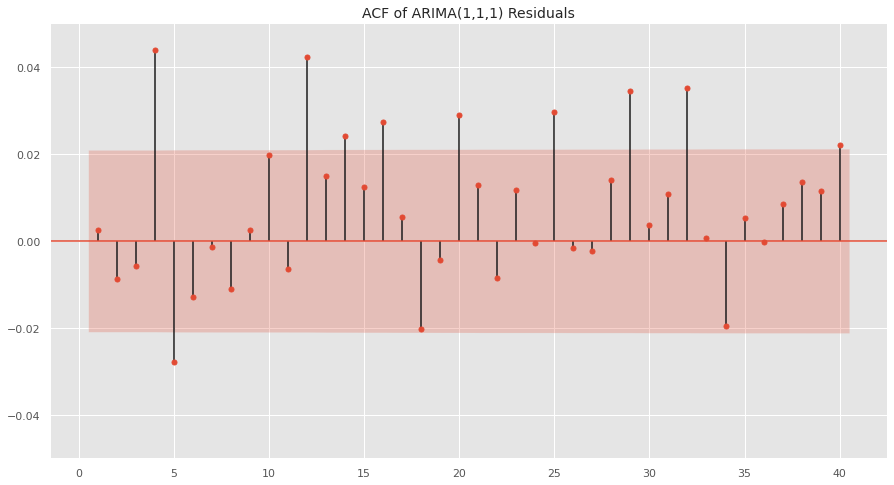

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(brent.ARIMA_Residuals[1:], zero=False, lags=40, ax = ax)
plt.title("ACF of ARIMA(1,1,1) Residuals", size=14)
ax.set_ylim(-0.05, 0.05)
plt.show();

4th and 5th lag seem to be highly significant and as such should be incorporated into the model. Let's try higher-lag ARIMA models which include lags up to 5.

In [ ]:
models_lst, ll_lst, aic_lst = [], [], []
for AR in range(1,6):
  for MA in range(1,6):
    globals()[f"model_ar_{AR}_i_1_ma_{MA}"] = ARIMA(brent.Close, order=(AR,1,MA))
    globals()[f"results_ar_{AR}_i_1_ma_{MA}"] = globals()[f"model_ar_{AR}_i_1_ma_{MA}"].fit() # start_ar_lag = 5
    if all(globals()[f"results_ar_{AR}_i_1_ma_{MA}"].pvalues<0.05):
      models_lst.append(f"ARIMA({AR},1,{MA})")
      ll_lst.append(globals()[f"results_ar_{AR}_i_1_ma_{MA}"].llf.round(2))
      aic_lst.append(globals()[f"results_ar_{AR}_i_1_ma_{MA}"].aic.round(2))
    print("#"*100")
    print(f"ARIMA({AR},1,{MA})")
    print(globals()[f"results_ar_{AR}_i_1_ma_{MA}"].summary())

results_dict = {#"model":models_lst,
                "LL": ll_lst,
                "AIC": aic_lst}
results_df = pd.DataFrame(results_dict, index = models_lst)
results_df.sort_values(by = "LL", ascending = False)
results_df 

####################################################################################################
ARIMA(1,1,1)
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8792
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14240.655
Date:                Tue, 27 Dec 2022   AIC                          28487.310
Time:                        16:39:19   BIC                          28508.555
Sample:                             0   HQIC                         28494.548
                               - 8792                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4563      0.109      4.194      0.000       0.243       0.669
ma.L1         -0.

,LL,AIC
"ARIMA(1,1,1)",-14240.66,28487.31
"ARIMA(1,1,3)",-14233.92,28477.84
"ARIMA(1,1,4)",-14230.20,28472.40
"ARIMA(2,1,2)",-14238.29,28486.58
"ARIMA(2,1,3)",-14226.79,28465.58
"ARIMA(3,1,1)",-14233.40,28476.80
"ARIMA(3,1,2)",-14226.90,28465.80
"ARIMA(3,1,5)",-14225.30,28468.60
"ARIMA(4,1,1)",-14229.94,28471.89
"ARIMA(4,1,5)",-14216.14,28452.28


Out of 25 models checked, 12 yielded all significant coefficients.

We should set our focus on highest LL and lowest AIC hence ARIMA(4,1,5) seems to be a contender for our top choice.

Before final verdict is given, Log-Likelihood tests will be conducted to check if extra complexity is justified.

In [ ]:
print("\nLLR test p-value = " + str(LLR_test( model_ar_1_i_1_ma_1, model_ar_4_i_1_ma_5, deg_of_fred = 7)))


LLR test p-value = 0.0


The result suggest that the choice should be made in favor of the more complex model of ARIMA(4,1,5) after all.

Let's see residuals and the corresponding ACF plot.

In [ ]:
brent["ARIMA_Residuals"] = results_ar_4_i_1_ma_5.resid[1:]

In [ ]:
brent.ARIMA_Residuals.mean()

0.006424901170112709

In [ ]:
brent.ARIMA_Residuals.var()

1.4865298416444301

In [ ]:
sts.adfuller(brent.ARIMA_Residuals[1:])

(-22.238060480240275,
 0.0,
 17,
 8773,
 {'1%': -3.431095607477787,
  '5%': -2.861869509077551,
  '10%': -2.566945392703401},
 28339.267440444066)

Mean of Residuals close to zero, reasonable variance and confirmation of stationarity allows us to assume white noise characteristics. Now time to plot ACF and examine the coefficients... 

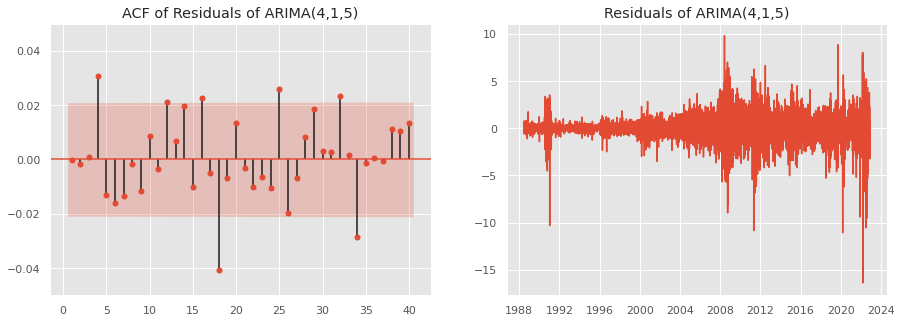

In [ ]:
f = plt.figure(figsize = (15,5))
ax1, ax2 = f.add_subplot(121), f.add_subplot(122)
plot_acf(brent.ARIMA_Residuals[1:], zero=False, lags=40, ax = ax1)
ax1.set_title("ACF of Residuals of ARIMA(4,1,5)")
ax1.set_ylim(-0.05, 0.05)
ax2.plot(brent.ARIMA_Residuals)
ax2.set_title("Residuals of ARIMA(4,1,5)")
plt.show();

**ACF** - surprisingly coefficient at lag 4 is still significant. All other till lag 12 are not. Coefficients at more distant lags should be ignored as a) their relevance diminishes b) adding complexity to the model would put us at risk of overfitting to the data and loosing forecasting capacity for unseen data. 

**Residuals** - unsurprisingly we observe elevetaed volatility around 1) financial crisis 2) Arab spring 3) Covid pandemic 4) war in Ukraine. Overall, claim of white noise characteristic is justified as ADF test confirmed its stationarity).

**Auto ARIMA**

The solution saves time, removes ambiguity and reduces risk of human error but comes at a cost of loosing insight into how well some other models perform. Let's try it anyway...

In [ ]:
model_auto = auto_arima(brent.Close[1:], m=5, max_order = None,
                        max_p = 5, max_q = 5, max_d=1,
                        max_P = 1, max_Q = 1, max_D=1,
                        maxiter = 25, alpha = 0.05, n_jobs = -1, trend = "ct")

In [ ]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8791
Model:               SARIMAX(2, 1, 4)   Log Likelihood              -14227.631
Date:                Mon, 12 Dec 2022   AIC                          28473.263
Time:                        09:54:49   BIC                          28536.995
Sample:                             0   HQIC                         28494.975
                               - 8791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0087      0.068      0.128      0.898      -0.124       0.142
drift      -1.024e-07   1.05e-05     -0.010      0.992   -2.06e-05    2.04e-05
ar.L1         -0.3907      0.146     -2.672      0.008      -0.677      -0.104
ar.L2         -0.2390      0.135     -1.764      0.078      -0.504       0.027
ma.L1          0.3589      0.146      2.450      0.014       0.072       0.646
ma.L2          0.2024      0.133      1.518      0.129      -0.059       0.464
ma.L3         -0.0307      0.009     -3.406      0.001      -0.048      -0.013
ma.L4          0.0313      0.009      3.651      0.000       0.014       0.048
sigma2         1.4937      0.009    165.516      0.000       1.476       1.511
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             63933.96
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              10.16   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The experiment yielded surprising model of ARIMA(2,1,4) which in the earlier part of the document did not have all significant coefficients. Let's now attempt to include seasonal component in the grid-search framework below...

**SARIMA Grid Search**

The solution of grid searching often helps to discover non-intuitive configurations that result in lower forecast error than those specified "manually". Most suitable parameters found in the process are:
1.   order => (p, d , q)
2.   seasonal_order => (P, D, Q, m)
3.   trend => one of 4 options: a) no trend b) constant c) linear d) constant w/h linear






In [ ]:
def sarima_model_configs(seasonal = [5]):
  configuration_list = []
  d = range(1,2)
  D = range(0,1)
  p = q = range(1,6)
  P = Q = range(0,2)
  pdq = list(itertools.product(p,d,q))  
  PDQS = list(itertools.product(P,D,Q,seasonal))
  for combination in pdq:
    for seasonal_combination in PDQS:
      try:
        configuration = (combination, seasonal_combination)
        configuration_list.append(configuration)
      except:
        continue
  return configuration_list

def sarima_forecast(data, configuration):
  try:
      model = SARIMAX(data, order = configuration[0], seasonal_order = configuration[1], #trend = trend, 
                      enforce_stationarity = False, enforce_invertibility = False)
      fitted_model = model.fit(disp = False)
      y_hat = np.round(fitted_model.predict(len(data), len(data)),3)
      return y_hat.values[0]
  except:
      return None

def avg_sarima_error(train_data, test_data, configuration, iterator):
  start_time = timer() #dt.datetime.now()
  archive = train_data.copy()
  predictions = list()
  for i in range(len(test_data)):
    y_hat = sarima_forecast(archive, configuration)
    predictions.append(y_hat)
    archive = pd.concat([archive, test_data[i:i+1]])
  try:
    fcast_error = np.round(assess_predictions(np.array(test_data), np.array(predictions)),3)
  except:
    fcast_error = None
  end_time = timer() #dt.datetime.now()
  print(f"Model: {iterator+1} \t Error: {fcast_error} \t \t Configuration: {configuration} \t Time: {round((end_time - start_time)/60,2)}")
  return (fcast_error, configuration)

def sarima_grid_search(train_set, test_set, conf_options):
  start_point = timer()
  sarima_results = [avg_sarima_error(train_data = train_set, test_data = test_set, configuration = config, iterator=index) for index, config in enumerate(conf_options)]
  sarima_results = [r for r in sarima_results if r[0] != None]
  sarima_results.sort(key=lambda tup: tup[0])
  end_point = timer()
  print(f"\n Total of {len(conf_options)} models calculated in {round((end_point - start_point)/60,2)} minutes.")
  return sarima_results

In [ ]:
sarima_conf_list = sarima_model_configs()
print(len(sarima_conf_list))

100


We have got 100 models to run here which is computationally expensive. Let us limit data to the most recent 7 years.

In [ ]:
yyyy, mm, dd = dt.date.today().year - 7, dt.date.today().month, dt.date.today().day
cut_off_date = dt.date(yyyy, mm, dd)
brent_subset = brent.loc[cut_off_date:].copy()
brent_train, brent_test = train_test_splitting(brent_subset.Close)

sarima_gs = sarima_grid_search(train_set = brent_train, test_set = brent_test, conf_options = sarima_conf_list)
print("\n TOP 5")
for result in sarima_gs[:5]:
  print(result)

Model: 1 	 Error: 2.956 	 	 Configuration: ((1, 1, 1), (0, 0, 0, 5)) 	 Time: 0.46
Model: 2 	 Error: 2.955 	 	 Configuration: ((1, 1, 1), (0, 0, 1, 5)) 	 Time: 0.82
Model: 3 	 Error: 2.958 	 	 Configuration: ((1, 1, 1), (1, 0, 0, 5)) 	 Time: 0.68
Model: 4 	 Error: 2.957 	 	 Configuration: ((1, 1, 1), (1, 0, 1, 5)) 	 Time: 1.09
Model: 5 	 Error: 2.962 	 	 Configuration: ((1, 1, 2), (0, 0, 0, 5)) 	 Time: 0.61
Model: 6 	 Error: 2.959 	 	 Configuration: ((1, 1, 2), (0, 0, 1, 5)) 	 Time: 1.15
Model: 7 	 Error: 2.961 	 	 Configuration: ((1, 1, 2), (1, 0, 0, 5)) 	 Time: 0.85
Model: 8 	 Error: 2.962 	 	 Configuration: ((1, 1, 2), (1, 0, 1, 5)) 	 Time: 1.8
Model: 9 	 Error: 2.966 	 	 Configuration: ((1, 1, 3), (0, 0, 0, 5)) 	 Time: 0.78
Model: 10 	 Error: 2.964 	 	 Configuration: ((1, 1, 3), (0, 0, 1, 5)) 	 Time: 1.11
Model: 11 	 Error: 2.965 	 	 Configuration: ((1, 1, 3), (1, 0, 0, 5)) 	 Time: 1.04
Model: 12 	 Error: 2.964 	 	 Configuration: ((1, 1, 3), (1, 0, 1, 5)) 	 Time: 1.57
Model: 13 	 Er

It turns out that frm the entire universe of SARIMA models checked, best results yielded the one with order of (1,1,1) and seasonal order of (0,0,1,5).

## **ETS**

The technique od Holt-Winters Exponential Smoothing of Time Series may be implemented with use of Statsmodels library and can be extended to support data with: a) systematic trend b) seasonal component. The optimisation process helps to adapt relevant hyperparameters to a given datset. The examples of parameters that can be automatically tuned are:
1.   smoothing_level
2.   smoothing_slope
3.   smoothing_seasonal
4.   damping_slope

On the other hand there is some hyperparameters that cannot be tuned and must be specified by a user:
1.  trend
2.  dumped
3.  seasonal
4.  seasonal_periods
5.  use_boxcox









In [ ]:
def ets_model_configs(seasonal = [5]):
  ets_models = list()
  t_options = ['add'] #, 'mul'
  d_options = [True, False]
  s_options = ['add', 'mul', None]
  p_options = seasonal
  r_options = [True, False]
  for t in t_options:
    for d in d_options:
      for s in s_options:
        for p in p_options:
          for r in r_options:
            config = [t, d, s, p, r]
            ets_models.append(config)
  return ets_models

def ets_forecast(data, configuration):
  t, d, s, p, r = configuration
  try:
    model = ExponentialSmoothing(data, trend = t, damped = d, seasonal = s, seasonal_periods = p)
    fitted_model = model.fit(optimized=True, remove_bias = r) #, use_boxcox = b
    y_hat = fitted_model.predict(len(data), len(data))
    pred = np.round(y_hat.iloc[-1],3)
    return pred
  except:
      return None

def avg_ets_error(train_data, test_data, configuration, iterator): #
  start_time = timer()
  ets_archive = train_data.copy()
  ets_predictions = list()
  for i in range(len(test_data)):
    y_hat = ets_forecast(ets_archive, configuration)
    ets_predictions.append(y_hat)
    ets_archive = pd.concat([ets_archive, test_data[i:i+1]])
  try:
    ets_error = np.round(assess_predictions(np.array(test_data), np.array(ets_predictions)),3)
  except:
    ets_error = None
  end_time = timer() #dt.datetime.now()
  print(f"Model: {iterator+1} \t Error: {ets_error} \t \t Configuration: {configuration} \t \t Time: {round((end_time - start_time)/60,2)}")
  return (ets_error, configuration)

def ets_grid_search(train_set, test_set, ets_conf_options):
  start_point = timer()
  ets_results = [avg_ets_error(train_data = train_set, test_data = test_set, configuration = config, iterator=index) for index, config in enumerate(ets_conf_options)]
  ets_results = [r for r in ets_results if r[0] != None]
  ets_results.sort(key=lambda tup: tup[0])
  end_point = timer()
  print(f"\n Total of {len(ets_conf_options)} models calculated in {round((end_point - start_point)/60,2)} minutes.")
  return ets_results

In [ ]:
ets_confs = ets_model_configs()
ets_gs = ets_grid_search(train_set = brent_train,
                         test_set = brent_test,
                         ets_conf_options = ets_confs)
print("\n TOP 5")
for result in ets_gs[:5]:
  print(result)

Model: 1 	 Error: 2.968 	 	 Configuration: ['add', True, 'add', 5, True] 	 	 Time: 0.84
Model: 2 	 Error: 2.965 	 	 Configuration: ['add', True, 'add', 5, False] 	 	 Time: 0.84
Model: 3 	 Error: 2.975 	 	 Configuration: ['add', True, 'mul', 5, True] 	 	 Time: 0.85
Model: 4 	 Error: 2.972 	 	 Configuration: ['add', True, 'mul', 5, False] 	 	 Time: 0.83
Model: 5 	 Error: 2.965 	 	 Configuration: ['add', True, None, 5, True] 	 	 Time: 0.18
Model: 6 	 Error: 2.962 	 	 Configuration: ['add', True, None, 5, False] 	 	 Time: 0.18
Model: 7 	 Error: 2.966 	 	 Configuration: ['add', False, 'add', 5, True] 	 	 Time: 0.82
Model: 8 	 Error: 2.966 	 	 Configuration: ['add', False, 'add', 5, False] 	 	 Time: 0.82
Model: 9 	 Error: 2.973 	 	 Configuration: ['add', False, 'mul', 5, True] 	 	 Time: 0.82
Model: 10 	 Error: 2.973 	 	 Configuration: ['add', False, 'mul', 5, False] 	 	 Time: 0.82
Model: 11 	 Error: 2.964 	 	 Configuration: ['add', False, None, 5, True] 	 	 Time: 0.18
Model: 12 	 Error: 2.96

It turns out that from the entire universe of ETS models checked, best results yielded the one with the following configuration:

['add', True, None, 5, False].

## Naive forecast

After all the computations, we must now set some benchmark for the assessment of their effectiveness. The obvious choise is usually a naive model which assumes persistence of past data into the future (1 step in our particular setup).

In [ ]:
def naive_model_configs(lags = 3):
  n_options = [i for i in range(1, lags +1)]
  return n_options
  
def naive_forecast(data, configuration):
  return data[-configuration]

def avg_naive_error(train_data, test_data, configuration, iterator):
  start_time = timer()
  naive_archive = train_data.copy()
  naive_predictions = list()
  for i in range(len(test_data)):
    y_hat = naive_forecast(naive_archive, configuration)
    naive_predictions.append(y_hat)
    naive_archive = pd.concat([naive_archive, test_data[i:i+1]])
  try:
    naive_error = np.round(assess_predictions(np.array(test_data), np.array(naive_predictions)),3)
  except:
    naive_error = None
  end_time = timer() #dt.datetime.now()
  print(f"Model: {iterator+1} \t Error: {naive_error} \t \t Configuration: {configuration} \t \t Time: {round((end_time - start_time)/60,2)}")
  return (naive_error, configuration)

def naive_grid_search(train_set, test_set, naive_conf_options):
  start_point = timer()
  naive_results = [avg_naive_error(train_data = train_set, test_data = test_set, configuration = config, iterator=index) for index, config in enumerate(naive_conf_options)]
  naive_results = [r for r in naive_results if r[0] != None]
  naive_results.sort(key=lambda tup: tup[0])
  end_point = timer()
  print(f"\n Total of {len(naive_conf_options)} models calculated in {round((end_point - start_point)/60,2)} minutes.")
  return naive_results

In [ ]:
naive_confs = naive_model_configs(5)
naive_gs = naive_grid_search(train_set = brent_train,
                             test_set = brent_test,
                             naive_conf_options = naive_confs)

Model: 1 	 Error: 2.959 	 	 Configuration: 1 	 	 Time: 0.0
Model: 2 	 Error: 4.163 	 	 Configuration: 2 	 	 Time: 0.0
Model: 3 	 Error: 5.011 	 	 Configuration: 3 	 	 Time: 0.0
Model: 4 	 Error: 5.618 	 	 Configuration: 4 	 	 Time: 0.0
Model: 5 	 Error: 6.116 	 	 Configuration: 5 	 	 Time: 0.0

 Total of 5 models calculated in 0.0 minutes.


Without surprises, best results yielded a naive model with a lag of 1.

## Average forecast

In [ ]:
def average_model_configs(lags = 10):
  n_options = [i for i in range(2, lags + 1)]
  return n_options

def average_forecast(data, configuration):
  return np.round(np.mean(data[-configuration:]),3)

def avg_average_error(train_data, test_data, configuration, iterator):
  start_time = timer()
  average_archive = train_data.copy()
  average_predictions = list()
  for i in range(len(test_data)):
    y_hat = average_forecast(average_archive, configuration)
    average_predictions.append(y_hat)
    average_archive = pd.concat([average_archive, test_data[i:i+1]])
  try:
    average_error = np.round(assess_predictions(np.array(test_data), np.array(average_predictions)),3)
  except:
    average_error = None
  end_time = timer() #dt.datetime.now()
  print(f"Model: {iterator+1} \t Error: {average_error} \t \t Configuration: {configuration} \t \t Time: {round((end_time - start_time)/60,2)}")
  return (average_error, configuration)

def average_grid_search(train_set, test_set, average_conf_options):
  start_point = timer()
  average_results = [avg_average_error(train_data = train_set, test_data = test_set, configuration = config, iterator=index) for index, config in enumerate(average_conf_options)]
  average_results = [r for r in average_results if r[0] != None]
  average_results.sort(key=lambda tup: tup[0])
  end_point = timer()
  print(f"\n Total of {len(average_conf_options)} models calculated in {round((end_point - start_point)/60,2)} minutes.")
  return average_results


In [ ]:
average_confs = average_model_configs()
average_gs = average_grid_search(train_set = brent_train,
                                 test_set = brent_test,
                                 average_conf_options = average_confs)

Model: 1 	 Error: 3.294 	 	 Configuration: 2 	 	 Time: 0.0
Model: 2 	 Error: 3.619 	 	 Configuration: 3 	 	 Time: 0.0
Model: 3 	 Error: 3.894 	 	 Configuration: 4 	 	 Time: 0.0
Model: 4 	 Error: 4.136 	 	 Configuration: 5 	 	 Time: 0.0
Model: 5 	 Error: 4.313 	 	 Configuration: 6 	 	 Time: 0.0
Model: 6 	 Error: 4.465 	 	 Configuration: 7 	 	 Time: 0.0
Model: 7 	 Error: 4.588 	 	 Configuration: 8 	 	 Time: 0.0
Model: 8 	 Error: 4.667 	 	 Configuration: 9 	 	 Time: 0.0
Model: 9 	 Error: 4.729 	 	 Configuration: 10 	 	 Time: 0.0

 Total of 9 models calculated in 0.01 minutes.


Without surprises, best results yielded a model with a shortest period.

# **Executive Summary**

Time to collect results of the best 5 models of each class in a summary data frame.

In [ ]:
results_df = pd.DataFrame({'naive':[i[0] for i in naive_gs[:5]],
                           'average':[i[0] for i in average_gs[:5]],
                           'sarima':[i[0] for i in sarima_gs[:5]],
                           'ets':[i[0] for i in ets_gs[:5]]},
                            index = np.arange(1,6))
results_df

,naive,average,sarima,ets
1,2.959,3.294,2.955,2.962
2,4.163,3.619,2.956,2.964
3,5.011,3.894,2.957,2.964
4,5.618,4.136,2.958,2.965
5,6.116,4.313,2.959,2.965


It would not be a bad idea to visualize the results.

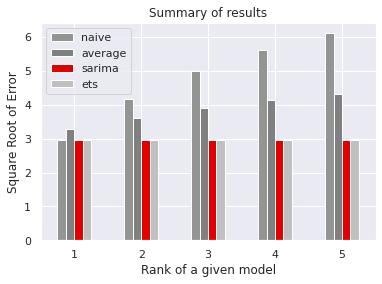

In [ ]:
results_df.plot.bar(color=['#929591', '#808080', '#E50000', '#C0C0C0'])
plt.title("Summary of results")
plt.xlabel("Rank of a given model")
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel("Square Root of Error");

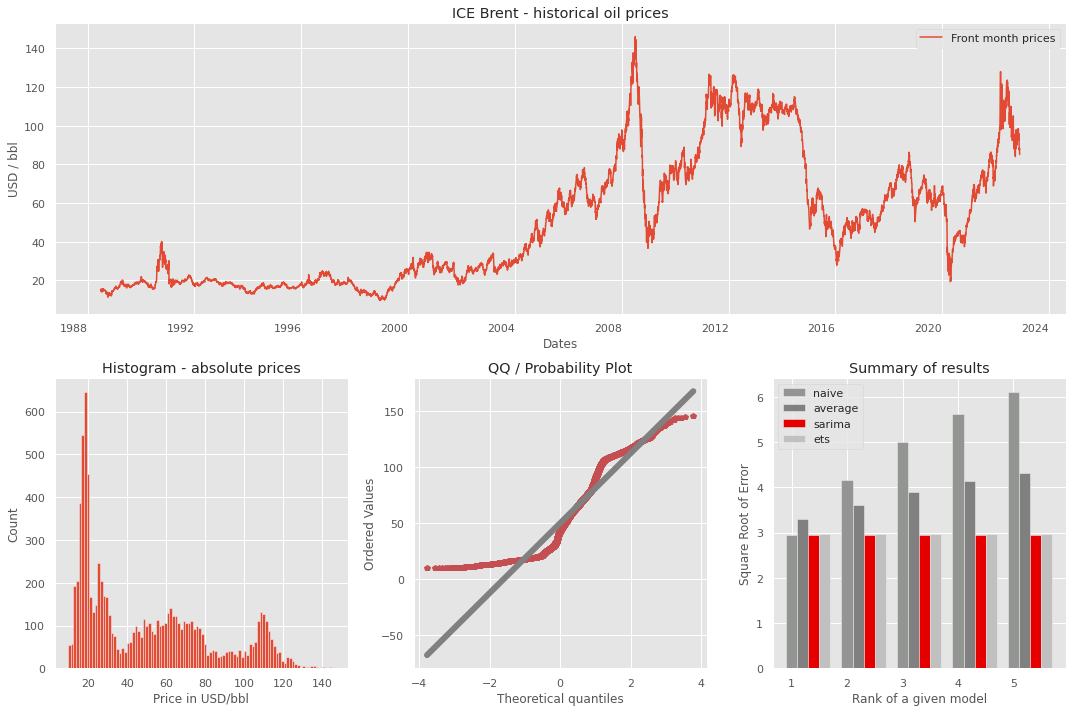

In [87]:
plt.figure(figsize = (15,10))

plt.subplot(2, 1, 1)
brent.Close.plot(label = "Front month prices")
plt.title("ICE Brent - historical oil prices")
plt.ylabel("USD / bbl")
plt.xlabel("Dates")
plt.xticks(rotation = 0)
plt.legend()
    
plt.subplot(2, 3, 4)
plt.hist(brent.Close, bins=100)
plt.title("Histogram - absolute prices")
plt.ylabel("Count")
plt.xlabel("Price in USD/bbl")

plt.subplot(2, 3, 5)
scipy.stats.probplot(brent.Close, plot = plt.subplot(2, 3, 5))
plt.gca().get_lines()[0].set_marker('p')
plt.gca().get_lines()[0].set_markerfacecolor('r')
plt.gca().get_lines()[0].set_markersize(6.0)
plt.gca().get_lines()[0].set_markeredgecolor("r")
plt.gca().get_lines()[1].set_linewidth(6.0)
plt.gca().get_lines()[1].set_color("grey")
plt.gca().set_title("QQ / Probability Plot")

plt.subplot(2, 3, 6)
plt.bar(results_df.index, results_df['naive'], color='#929591', label = 'naive', width=0.2)
plt.bar(results_df.index+0.2, results_df['average'], color='#808080', label = 'average', width=0.2)
plt.bar(results_df.index+0.4, results_df['sarima'], color='#E50000', label = 'sarima', width=0.2)
plt.bar(results_df.index+0.6, results_df['ets'], color='#C0C0C0', label = 'ets', width=0.2)
plt.legend()
plt.title("Summary of results")
plt.xlabel("Rank of a given model")
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel("Square Root of Error")

plt.tight_layout();

**Key takeaways:**



> * Brent crude oil prices on ICE resemble a random walk process
> * Crude oil prices do not represent a stationary process but may be transformed into stationary form by first differencing
> * Absolute prices tend to cluster either around 65 USD/bbl in low price environment or 110 USD/bbl in high price environment
> * QQ plot clearly demonstrates that Brent prices do not follow normal distribution which prevents us from using its elegant statistics
> * From the models tested SARIMA((1, 1, 1), (0, 0, 1, 5)) has beaten the baseline model but margin of improvement was not wide enough to argue that it shows skills

In the next part we will attempt to verify whether deep learning holds any promise in modelling Brent prices...

